## 非線形分位点回帰

### 内容
* Qiitaの記事と連動しています
* statsmodels.apiを利用して分位点回帰の演習を行います
* 分位点を利用した線形回帰モデルの演習です。statsmodelsを使えばOLSによる回帰分析同様簡単に求めることができます
* 3種類の分位点（0.1, 0.5, 0.9）を二次関数と指数関数モデルで推定
* OLSと分位点（0.5）で比較

### スポーツ飲料と気温の関係
* [全国清涼飲料連合会](https://www.j-sda.or.jp/index.php)
* [気象庁共同プロジェクト](https://www.j-sda.or.jp/about/comprehensive_measures/weather/kekka04.php)
* 気象庁共同プロジェクトからDL4.xlsファイルをダウンロード、sports_temp.csvとファイル名を変更して利用します

* グラフの形から、線形よりも指数関数や２次関数のほうがフィットしてそう
* 気象庁共同プロジェクトのwebページでは指数関数での推定が行われている

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.model_selection import train_test_split

## データの読み込みと２乗データの作成
* 二次関数で回帰分析すると言っても、$x^2$のデータ項目を追加するだけ
$$
販売指数 = a + b_1 \cdot 気温 + b_2 \cdot気温^2
$$
と考えれば、
$$
y = a + b_1 x_1 + b_2 x_2
$$
という線形回帰とみなすことができる。

* 気温の２乗データ列を作成して、２変数の線形回帰と思えばOK

In [2]:
df = pd.read_csv("./data/sports_temp.csv")
df["平均気温2"] = df["平均気温"]**2
df.head(5)

,年月日,平均気温,販売指数,週別指数,週別気温,平均気温2
0,2014/4/1,13.9,2.263703,NaN,NaN,193.21
1,2014/4/2,15.2,1.697737,NaN,NaN,231.04
2,2014/4/3,13.8,1.407450,NaN,NaN,190.44
3,2014/4/4,15.3,1.209598,NaN,NaN,234.09
4,2014/4/5,11.4,1.206834,1.227821,13.157143,129.96


### 訓練データとテストデータに分割

データ数も多いので、テストデータを残して、分位点回帰での予測の範囲に収まるかチェック

In [3]:
x = df[["平均気温", "平均気温2"]]
t = df["販売指数"]
x_train, x_test, t_train, t_test = train_test_split(x,t, random_state=55)
x_train.head()

,平均気温,平均気温2
467,27.2,739.84
118,27.7,767.29
967,11.4,129.96
347,8.9,79.21
718,14.9,222.01


## 二次関数モデル
* 二次関数とはいっても2乗データがあるので$y = a + b_1 平均気温 + b_2 平均気温^2$という線形モデルと同じように扱える


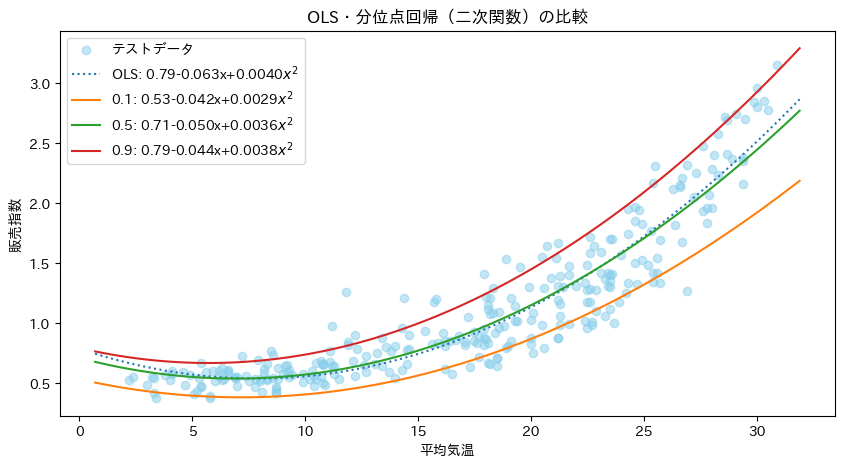

In [4]:
taus = [0.1, 0.5, 0.9]

# 説明変数と目的変数を設定
y = t_train
X = sm.add_constant(x_train)

# 予測曲線を滑らかに描くために、気温の範囲を細かく設定
temp_range = np.linspace(df["平均気温"].min(), df["平均気温"].max(), 100)
predict_df = pd.DataFrame({"平均気温": temp_range, "平均気温2": temp_range ** 2})
predict_df = sm.add_constant(predict_df)


# OLS 二次関数
ols_model = sm.OLS(endog=y, exog=X)
ols_result = ols_model.fit()
ols_a = ols_result.params.const
ols_b = ols_result.params.平均気温
ols_c = ols_result.params.平均気温2
ols_label = f"OLS: {ols_a:.2f}{ols_b:.3f}x+{ols_c:.4f}$x^2$"


# 分位点回帰
model = sm.QuantReg(endog=y, exog=X)


# グラフ描画のための設定
fig, ax = plt.subplots(figsize=(10,5))

# テストデータの散布図
ax.scatter(x_test["平均気温"], t_test, color="skyblue", label="テストデータ", alpha=0.5)

# OLS線形回帰のプロット
# 平均気温が一定間隔で並んでいるpredict_dfを使ってグラフを描画
ols_predicted_sales = ols_result.predict(predict_df)
ax.plot(temp_range, ols_predicted_sales, label=ols_label, linestyle="dotted")


for t in taus:
    result = model.fit(q=t)
    a = result.params.const
    b1 = result.params.平均気温
    b2 = result.params.平均気温2
    sign1 = "+" if b1 >= 0 else "-"
    sign2 = "+" if b2 >= 0 else "-"
    label = f"{t}: {a:.2f}{sign1}{abs(b1):.3f}x{sign2}{abs(b2):.4f}$x^2$"

    # モデルを使って予測値を計算
    predicted_sales = result.predict(predict_df)
    ax.plot(temp_range, predicted_sales, label=label)

# グラフのタイトルとラベルを設定
ax.set_title("OLS・分位点回帰（二次関数）の比較")
ax.set_xlabel("平均気温")
ax.set_ylabel("販売指数")
ax.legend()
plt.show()

## 指数関数による近似
* $y= a+e^bx$の場合、両辺対数をとる
* $\log y = \log a + bx$と変形する。$y=a+bx$の形になっている
* 目的変数は、$\log y$に、切片が$\log a$であることに注意して、通常の線形回帰すればOK

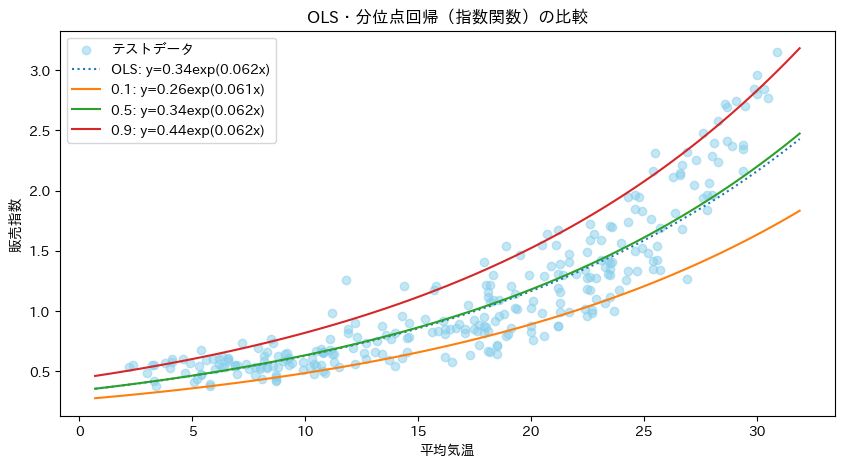

In [5]:
taus = [0.1, 0.5, 0.9]


X = sm.add_constant(x_train["平均気温"])
y = t_train
log_y = np.log(y)

# 予測曲線を滑らかに描くために、気温の範囲を細かく設定
temp_range = np.linspace(df["平均気温"].min(), df["平均気温"].max(), 100)
predict_df = pd.DataFrame({"平均気温": temp_range})
predict_df = sm.add_constant(predict_df)

# 指数関数の回帰
ols_model = sm.OLS(log_y, X)
ols_result = ols_model.fit()
ols_a = np.exp(ols_result.params.const)   # 元の関数のa
ols_b = ols_result.params.平均気温        # 元の関数のb
predicted_sales = ols_result.predict(predict_df)
y_pred_ols = np.exp(predicted_sales)
ols_label = f"OLS: y={ols_a:.2f}exp({ols_b:.3f}x)"

# 分位点回帰での計算
qr_model = sm.QuantReg(log_y, X)


# グラフ描画のための設定
fig, ax = plt.subplots(figsize=(10,5))
# テストデータの散布図
ax.scatter(x_test["平均気温"], t_test, color="skyblue", label="テストデータ", alpha=0.5)

# OLS回帰のプロット
# 平均気温が一定間隔で並んでいるpredict_dfを使ってグラフを描画
ax.plot(temp_range, y_pred_ols, label=ols_label, linestyle="dotted")


# グラフ表示
for t in taus:
    qr_result = qr_model.fit(q=t)      # t-分位点回帰
    predicted_sales = qr_result.predict(predict_df)
    y_pred_qr = np.exp(predicted_sales) # 予測値を元に戻す
    a = np.exp(qr_result.params.const)  # 元の関数のa
    b = qr_result.params.平均気温
    qr_label = f"{t}: y={a:.2f}exp({b:.3f}x)"
    ax.plot(temp_range, y_pred_qr, label=qr_label)

# グラフのタイトルとラベルを設定
ax.set_title("OLS・分位点回帰（指数関数）の比較")
ax.set_xlabel("平均気温")
ax.set_ylabel("販売指数")
ax.legend()
plt.show()